# IMDB Movie Sentiment Analasis

In this notebook, we will use the IMDB movie reviews dataset, provided on Kaggle (https://www.kaggle.com/c/word2vec-nlp-tutorial/data), to build a sentiment analysis model using NLP. 

Rather than using the Word2Vec model (which provided little to no gains in our score), this time we will be using the Doc2Vec model which will consider the order of words in our review as well, giving us not only each word's average feature vector, but also the whole review's average feature vector as well. Through this, we hope to improve our score. 

## Importing the Data

In [404]:
import numpy as np
import pandas as pd # to read the csv datasets and import them into python

In [405]:
data_path = "data" # path to the data folder in your directory
# import the labeled and unlabeled training data to train our model
train_1 = pd.read_csv(data_path + "/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3) 
train_2 = pd.read_csv(data_path + "/imdb_master.csv", encoding="latin-1") 



In [406]:
train_2 = train_2.drop(["Unnamed: 0","type","file"],axis=1)
train_2.columns = ["review","sentiment"]

In [407]:
train_2 = train_2[train_2.sentiment != 'unsup']
train_2['sentiment'] = train_2['sentiment'].map({'pos': 1, 'neg': 0})

In [408]:
train = pd.concat([train_1, train_2]).reset_index(drop=True)

## Preprocessing

In [409]:
from bs4 import BeautifulSoup # to get rid of the HTML tags in the reviews
import re # to remove punctuations and numericals from the review

from nltk.corpus import stopwords # to remove the stop words in our reviews and obtain our tokenizer
from nltk.stem import WordNetLemmatizer # to lemmatize our reviews
from nltk import word_tokenize
import nltk.data
nltk.download()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [410]:
def preprocess_review(unclean_review):
    """ 
    Function that takes a single unclean review from the original dataset
    and returns a cleaned and preprocessed version of it. 
    Input: string: an uncleaned review from the dataset
    Output: string: cleaned and preprocessed review
    """
    # removes the HTML tags in the review
    untagged_review = BeautifulSoup(unclean_review).get_text() 
    # removes everything not in A-Z or a-z and replaces it with a space
    letter_only_review = re.sub("[^a-zA-Z]", " ", untagged_review) 
    # converting everything to lowercase
    letter_only_review = letter_only_review.lower() 
    # converting everything to tokenized words
    tokenized_review = word_tokenize(letter_only_review)
    # taking only the lemmatized words
    tokens = list(map(lemmatizer.lemmatize, tokenized_review))
    # only accepting the verbs from those lemmatized words to normalize process
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # removing all the stop words in the review
    result = [t for t in lemmatized_tokens if not t in stop_words]
    return " ".join(result)


## Training the Model

In [411]:
# clean up the reviews
x_train = []
for i in range(len(train["review"])):
    if i % 10000 == 0:
        print(i)
    x_train.append(preprocess_review(train["review"][i]))
    
y_train = train.sentiment.values

0
10000
20000
30000
40000
50000
60000
70000


In [412]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 5000 # we will keep the 5000 most freq words for our model
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
train_tokens = tokenizer.texts_to_sequences(x_train)

max_length = 130
x_train = pad_sequences(train_tokens, maxlen=max_length)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, shuffle=True)
embedding_size = 128
model = Sequential()
model.add(Embedding(max_features, embedding_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 8
history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), 
          batch_size=batch_size, epochs=epochs)


C:\Users\yasoo\Anaconda3\envs\walmart1\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 67500 samples, validate on 7500 samples
Epoch 1/8
67500/67500 [==============================] - 111s 2ms/step - loss: 0.3199 - accuracy: 0.8636 - val_loss: 0.2497 - val_accuracy: 0.9003
Epoch 2/8
67500/67500 [==============================] - 113s 2ms/step - loss: 0.2103 - accuracy: 0.9207 - val_loss: 0.2285 - val_accuracy: 0.9123
Epoch 3/8
67500/67500 [==============================] - 117s 2ms/step - loss: 0.1586 - accuracy: 0.9443 - val_loss: 0.2161 - val_accuracy: 0.9228
Epoch 4/8
67500/67500 [==============================] - 116s 2ms/step - loss: 0.1177 - accuracy: 0.9603 - val_loss: 0.2189 - val_accuracy: 0.9296
Epoch 5/8
67500/67500 [==============================] - 116s 2ms/step - loss: 0.0820 - accuracy: 0.9739 - val_loss: 0.2325 - val_accuracy: 0.9335
Epoch 6/8
67500/67500 [==============================] - 119s 2ms/step - loss: 0.0584 - accuracy: 0.9828 - val_loss: 0.2360 - val_accuracy: 0.9349
Epoch 7/8
67500/67500 [==============================] - 118s 2ms/ste

## Output Model Results

In [413]:
# import the test data to evaluate our model
result_data = pd.read_csv(data_path + "/testData.tsv", header=0, delimiter="\t", quoting=3)

In [414]:
result_data["review"] = result_data.review.apply(lambda x: preprocess_review(x))

In [415]:
result_data["sentiment"] = result_data["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

In [416]:
y_result = result_data["sentiment"]
reviews = result_data["review"]
tokenized = tokenizer.texts_to_sequences(reviews)
x_result = pad_sequences(tokenized, maxlen=max_length)

In [417]:
predictions = model.predict(x_result)

In [418]:
y_result_pred = (predictions > 0.5)

In [419]:
# to obtain the area under ROC score
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_result_pred, y_result)))
print('Confusion matrix:')
confusion_matrix(y_result_pred, y_result)

F1-score: 0.9769425777634704
Confusion matrix:


array([[12288,   361],
       [  212, 12139]], dtype=int64)

In [420]:
y_result_pred = y_result_pred.astype(int)

In [421]:
y_result_pred = [item for items in y_result_pred for item in items]

In [422]:
output = pd.DataFrame(data={"id":test_data["id"], "sentiment":y_result_pred} )
output.to_csv( "cnn_model.csv", index=False, quoting=3 )

In [423]:
output

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",0
3,"""7186_2""",0
4,"""12128_7""",1
...,...,...
24995,"""2155_10""",1
24996,"""59_10""",1
24997,"""2531_1""",0
24998,"""7772_8""",1


## Visualizing the Model

In this part, we will visualize the confusion matrix and the model accuracy/loss curves, using guidance from <a href="https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc">here</a>

In [424]:
y_train_predictions = model.predict_classes(x_train)
y_test_predictions = model.predict_classes(x_test)

In [425]:
# library to plot the confusion matrix and our curves
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sb


# function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1, fontsize=16)
    ax.set_ylabel('True labels', fontsize=16)
    ax.set_xlabel('Predicted labels', y=1, fontsize=16)
    ax.set_yticklabels(class_names, rotation=0)
    


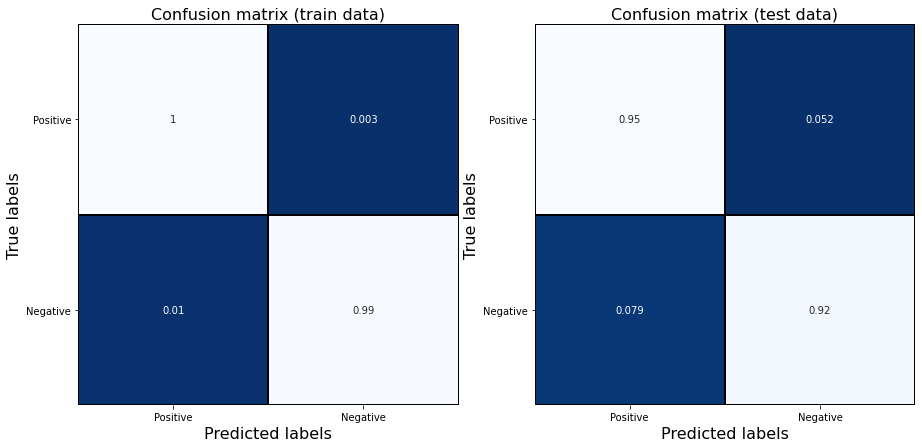

In [426]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
plot_confusion_matrix(y_train, y_train_predictions, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_predictions, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

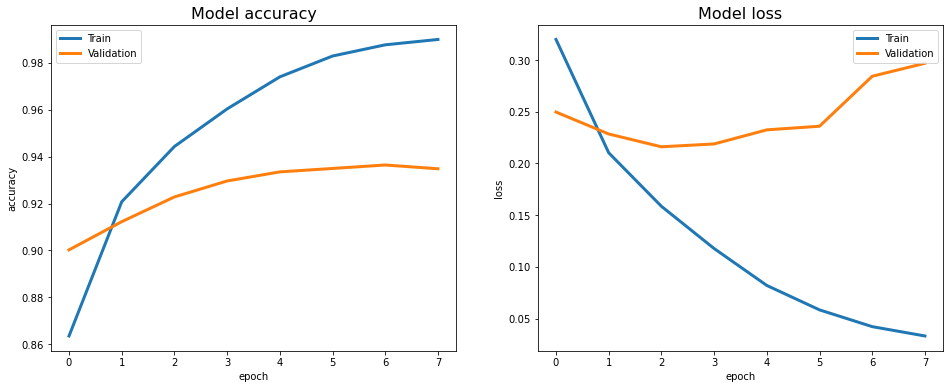

In [427]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

## Analysis

How many movie reviews are positive and how many are negative in labeledTrainData.tsv? Do we have balance between the classes?


Text(0, 0.5, 'Num of reviews')

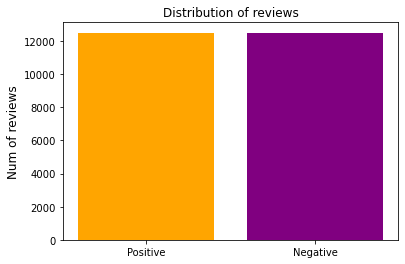

In [451]:
positive = train_1[train_1.sentiment == 1]
negative = train_1[train_1.sentiment == 0]
x = ["Positive", "Negative"]
y = [len(positive), len(negative)]
plt.bar(x, y, color=["orange", "purple"])
plt.title("Distribution of reviews")
plt.ylabel("Num of reviews", fontsize=12)

As we can observe, both the positive and negative reviews are equally balanced (12,500 each) in the labeledTrainData.tsv